<a href="https://colab.research.google.com/github/kusumakk12/Twitter_sentiment_analysis_DA/blob/main/nexus_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nexus/nexus_p2/twitter_dataset.csv', encoding="latin1", header=None, names=["target", "id", "date", "flag", "user", "text"])
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1048576 rows and 6 columns


In [ ]:
# Data Exploration
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1048576 non-null  int64 
 1   id      1048576 non-null  int64 
 2   date    1048576 non-null  object
 3   flag    1048576 non-null  object
 4   user    1048576 non-null  object
 5   text    1048576 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB
None
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, 

# Data Cleaning
# Handle missing values, duplicate entries, and irrelevant information


In [ ]:
# Drop irrelevant columns
df = df[['target','date','text']]

# Handle missing values
df.dropna(inplace=True)

# Remove duplicate entries
df.drop_duplicates(inplace=True)

# Remove unnecessary columns or features
# Adjust this based on your dataset's structure
# Example: df = df[['target', 'text']]

# Convert target labels to a more interpretable format
df['sentiment'] = df['target'].map({0: 'Negative', 2: 'Neutral', 4: 'Positive'})

# Drop the original 'target' column
#df.drop('target', axis=1, inplace=True)

# Remove special characters, URLs, and extra whitespaces from the text
df['cleaned_text'] = df['text'].str.replace(r'http\S+|www.\S+|[^a-zA-Z\s]', '', regex=True)

# Convert text to lowercase
df['cleaned_text'] = df['cleaned_text'].str.lower()

# Display the cleaned dataset
print(df.head())

   target                          date  \
0       0  Mon Apr 06 22:19:45 PDT 2009   
1       0  Mon Apr 06 22:19:49 PDT 2009   
2       0  Mon Apr 06 22:19:53 PDT 2009   
3       0  Mon Apr 06 22:19:57 PDT 2009   
4       0  Mon Apr 06 22:19:57 PDT 2009   

                                                text sentiment  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  Negative   
1  is upset that he can't update his Facebook by ...  Negative   
2  @Kenichan I dived many times for the ball. Man...  Negative   
3    my whole body feels itchy and like its on fire   Negative   
4  @nationwideclass no, it's not behaving at all....  Negative   

                                        cleaned_text  
0  switchfoot   awww thats a bummer  you shoulda ...  
1  is upset that he cant update his facebook by t...  
2  kenichan i dived many times for the ball manag...  
3    my whole body feels itchy and like its on fire   
4  nationwideclass no its not behaving at all im ...  


# Exploratory Data Analysis (EDA)

In [ ]:
# Explore dataset structure, features, and size
print(df.info())

# Display basic statistics for numerical features
print(df.describe())

# Identify key variables
print("Columns in the dataset:", df.columns)
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048323 entries, 0 to 1048575
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   target        1048323 non-null  int64 
 1   date          1048323 non-null  object
 2   text          1048323 non-null  object
 3   sentiment     1048323 non-null  object
 4   cleaned_text  1048323 non-null  object
dtypes: int64(1), object(4)
memory usage: 48.0+ MB
None
             target
count  1.048323e+06
mean   9.481696e-01
std    1.701075e+00
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    4.000000e+00
Columns in the dataset: Index(['target', 'date', 'text', 'sentiment', 'cleaned_text'], dtype='object')
target          0
date            0
text            0
sentiment       0
cleaned_text    0
dtype: int64


Sentiment distribution

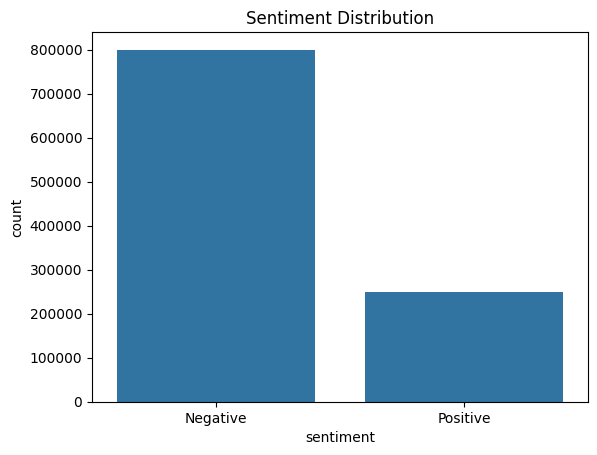

In [ ]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

Text Preprocessing

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+|pic.\S+|\S+.com\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# Apply text preprocessing to the 'cleaned_text' column
df['processed_text'] = df['cleaned_text'].apply(preprocess_text)
print(df.columns)

Index(['target', 'date', 'text', 'sentiment', 'cleaned_text',
       'processed_text'],
      dtype='object')


In [ ]:
#Display the processed dataset
print(df[['cleaned_text', 'processed_text']].head())

                                        cleaned_text  \
0  switchfoot   awww thats a bummer  you shoulda ...   
1  is upset that he cant update his facebook by t...   
2  kenichan i dived many times for the ball manag...   
3    my whole body feels itchy and like its on fire    
4  nationwideclass no its not behaving at all im ...   

                                      processed_text  
0  switchfoot bummer shoulda got david carr third...  
1  upset cant update facebook texting might cry r...  
2  kenichan dived many time ball managed save res...  
3                    whole body feel itchy like fire  
4           nationwideclass behaving im mad cant see  


Word frequency analysis(word cloud)

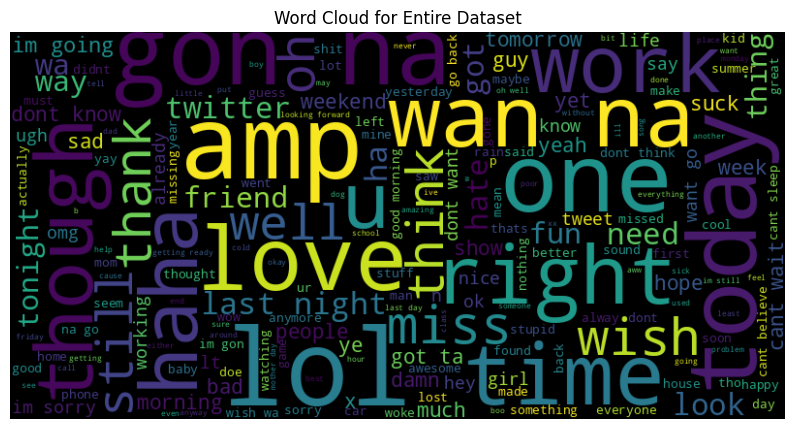

In [ ]:
# 'processed_text' column contains preprocessed text
all_words = ' '.join(df['processed_text'])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Entire Dataset')
plt.show()


 Temporal analysis

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


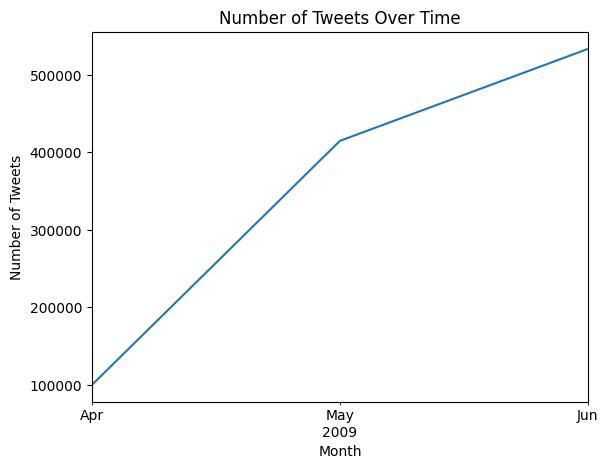

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.resample('M').size().plot(legend=False)
plt.title('Number of Tweets Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
# Display  few example tweets for each sentiment
for sentiment in df['sentiment'].unique():
    sample_tweets = df[df['sentiment'] == sentiment]['text'].sample(5, random_state=42)
    print(f"\nSample Tweets for {sentiment} Sentiment:")
    for tweet in sample_tweets:
        print("-", tweet)



Sample Tweets for Negative Sentiment:
- finished one shift at 2:30 and back there till 22:30 from 17:30 ergh  i cba today..xx someone else go for me please? xxxxxx
- @YoungQ I can't see that page 
- workk till 2 then homework forever  PITCH BLACKK!
- leaving vegas  cant wait to come back
- @m_carruthers yeah, i know  ive been so ill these last few days, havent had time to update site. moving house in 1 week too, busy busy bee

Sample Tweets for Positive Sentiment:
- @ericedelstein I don't think he's going to show the slides you're expecting  #netprophet
- @HardKnockLife heyyy wasssup 
- @ravensapphire whats up girl? 
- @whysogreen Haha that would look awesome, not to mention taking it all back and restoring it but putting in some nice upgrades 
- @RobertPattz ..cont..that was sooo unbelievable hilarious...really  I was laughing all the time  hats off to U man))) u should be


Sentiment Prediction Model

In [ ]:
# Splitting  the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Training Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Evaluating the model
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.8063673002170129
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89    159945
           4       0.87      0.22      0.35     49720

    accuracy                           0.81    209665
   macro avg       0.84      0.60      0.62    209665
weighted avg       0.82      0.81      0.76    209665

Confusion Matrix:
 [[158368   1577]
 [ 39021  10699]]


Feature Importance

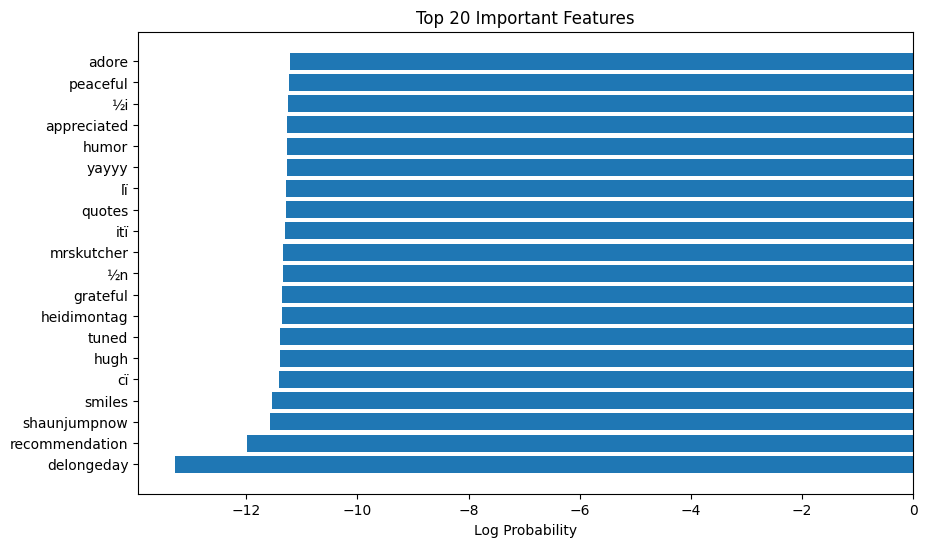

In [ ]:
# Get feature names and corresponding coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
log_probabilities = model.feature_log_prob_[0]
# Creating a DataFrame with feature names and log probabilities
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Log Probability': log_probabilities})

# Sorting the DataFrame by log probability to identify important features
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Log Probability'].abs().sort_values(ascending=False).index)
# Ploting the top N important features
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:top_n], feature_importance_df['Log Probability'][:top_n])
plt.xlabel('Log Probability')
plt.title('Top {} Important Features'.format(top_n))
plt.show()

User Interface testing the model

In [ ]:
custom_input = input("Enter a tweet for custom testing: ")
processed_custom_input = preprocess_input(custom_input)
predicted_sentiment_custom = model.predict(processed_custom_input)[0]
print(f"Custom Input: {custom_input}")
print(f"Predicted Sentiment: {sentiment_mapping[predicted_sentiment_custom]}")

Enter a tweet for custom testing: nice
Custom Input: nice
Predicted Sentiment: Positive
